## Delta hedging a European call option on the DAX index

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

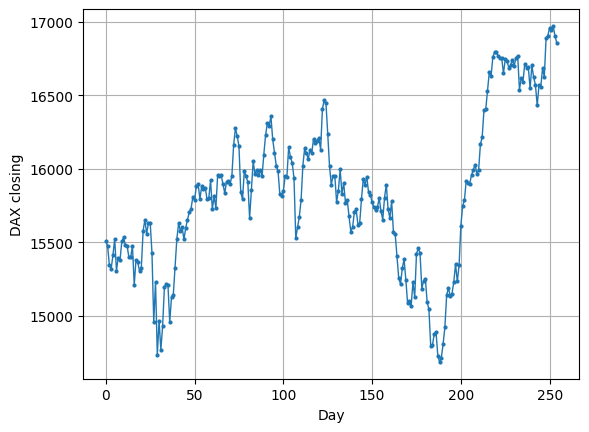

In [5]:
# Using German DAX index between 01 February 2023 and 31 January 2024 (255 trading days).
dax_prices = np.loadtxt('DAX_sample.csv')
plt.plot(dax_prices, marker = 'o', markersize = 2, linestyle='-', linewidth = 1)
plt.grid()
plt.xlabel('Day')
plt.ylabel('DAX closing')
plt.show()

In [8]:
def european_BS(t, St, K, T, r, sigma, call):
    
    d1 = ((np.log(St / K) + (r + 0.5 * sigma**2) * (T - t))) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    
    if call:
        return St * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    else:
        return K * np.exp(-r * (T - t)) * norm.cdf(-d2) - St * norm.cdf(-d1)

In [ ]:
# Calculating European Call prices
euribor = 0.03316
log_returns = np.diff(np.log(dax_prices))
sigma_new = np.std(log_returns)*np.sqrt(255)
call_prices_DAX = np.zeros(255)
print(sigma_new)

for i in range(255):
    t = i/255
    call_prices_DAX[i] = european_BS(t, dax_prices[i], 16000, 1, euribor, sigma_new, 1)

print(call_prices_DAX[:10])

0.12666149230651214
[798.0042159  778.21304584 709.07791681 694.2827161  737.48942064
 793.0239993  680.72283563 722.62941222 711.7225761  773.8953411 ]


In [ ]:
# Calculating the delta of a European call option in the Black-Scholes model at time t
def delta_call_BS(t, St, K, T, r, sigma):
    if T-t <= 0:
        return 1.0 if St>K else 0.0
    d1 = ((np.log(St / K) + (r + 0.5 * sigma**2) * (T-t))) / (sigma * np.sqrt(T-t)) 
    return norm.cdf(d1)

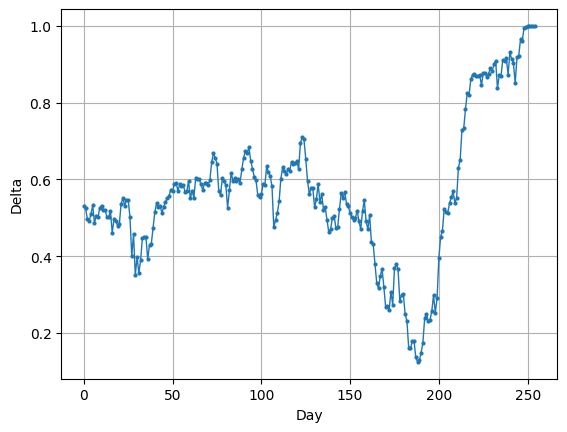

In [ ]:
# Calculating delta of the call option 
delta_DAX = np.zeros(255)
for i in range(255):
    t = i/255
    delta_DAX[i] = delta_call_BS(t, dax_prices[i], 16000, 1, euribor, sigma_new)

plt.plot(delta_DAX, marker = 'o', markersize = 2, linestyle='-', linewidth = 1)
plt.xlabel('Day')
plt.ylabel('Delta')
plt.grid()
plt.show()

Interpretation from this graph:

The delta of the DAX call option (i.e. the number of shares of the DAX that ones needs to hold at each point in time in a replicating portfolio of the option) oscillates between 0 and 1. This is true for any call option in any stochastic model because the derivative of the call option payoff with respect the stock price is bounded in the interval [0,1]. 

As the time t approaches the expiry of the option and as it becomes more and more likely that the option will finish in the money, the delta approaches 1. If the option had expired out of the money the delta would have approached 0.

Since the hedging portfolio can in reality not be rebalanced continuously, we have to rebalance it once every day: The investor makes sure at every day $t_i$ to hold $\delta(t_i)$ shares of the stock. The necessary money to fund these purchases are drawn from the bond investment to make the portfolio self-financing.

Defining two arrays by the initial investment of the replicating portfolio in the stock and in the bond, given by $\varphi_1(0) S(0) = \delta(0) S(0)$ and $\varphi_0(0) B(0) = V(0) - \varphi_1(0)$, respectively.

In [16]:
stock_investment = np.zeros(255)
bond_investment = np.zeros(255)

stock_investment[0] = delta_DAX[0]*dax_prices[0]
bond_investment[0] = call_prices_DAX[0]-stock_investment[0]

The stock investment at time $t_i$ is given by $\delta(t_i) S(t_i)$. The current bond investment $b(t_i)$ at time $t_i$ is given by $b(t_i) = b(t_{i-1}) e^{r \Delta t} - (\delta(t_i) - \delta(t_{i-1})) S(t_i)$.

In [17]:
for i in range(1, 255):
    stock_investment[i] = delta_DAX[i]*dax_prices[i]
    bond_investment[i] = bond_investment[i-1]*np.exp(euribor/255)-(delta_DAX[i]-delta_DAX[i-1])*dax_prices[i]

print(stock_investment[:10])
print(bond_investment[:10])

[8243.82320381 8116.47909153 7630.1968669  7530.59755236 7857.51727079
 8261.64480051 7458.76159114 7780.15941505 7710.22709    8169.96727401]
[-7445.81898791 -7336.85658183 -6919.97857697 -6833.72444873
 -7116.7205309  -7464.99386557 -6777.73974893 -7056.47864369
 -6995.94280431 -7393.53966997]


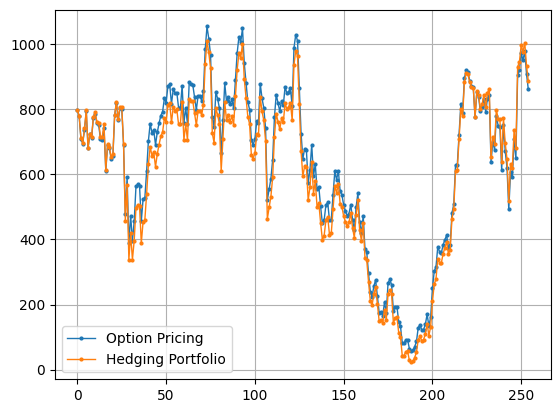

In [18]:
total_investment = stock_investment + bond_investment
plt.plot(call_prices_DAX, label = 'Option Pricing',  marker = 'o', markersize = 2, linestyle='-', linewidth = 1)
plt.plot(total_investment, label = 'Hedging Portfolio', marker = 'o', markersize = 2, linestyle='-', linewidth = 1)
plt.grid()
plt.legend()
plt.show()

Since the Black-Scholes model is complete (i.e. there exists a unique equivalent martingale measure in the model), options can theoretically perfectly hedged. The fact that the hedging portfolio still deviates over time from the option price originates from two sources of error: First, there is a discretization error. A perfect hedging portfolio in the Black-Scholes model would require a continuous rebalancing of the portfolio over time, which is in practice not possible. Since we rebalanced our portfolio quite frequently (once a day), the discretization error is not too large in this example. Second, there is a model error. A perfect hedge in the Black-Scholes model would only be possible if also the underlying of the option perfectly follows the stochastic dynamics of the Black-Scholes model, which is a geometric Brownian motion (GBM). Since the DAX however cannot be perfectly modeled by a GBM, perfect hedging is out of reach even if one could theoretically rebalance the hedging portfolio continuously over time to eliminate the discretization error.

In [ ]:
from scipy.integrate import quad

def delta_int(t, f, f_prime, St, T, r, sigma):
    tau = T - t  # time to maturity

    def integrand(x):
        exponent = (r - 0.5 * sigma**2) * tau + sigma * np.sqrt(tau) * x
        ST = St * np.exp(exponent)
        dST_dSt = np.exp(exponent)
        weight = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
        return f_prime(ST) * dST_dSt * weight

    delta, _ = quad(integrand, -10, 10)  # truncate integral for numerical stability
    return delta

In [20]:
K = 100
f = lambda ST: max(ST - K, 0)
f_prime = lambda ST: 1.0 if ST > K else 0.0

# Parameters
t = 0
St = 120
T = 1
r = 0.02
sigma = 0.3

delta = delta_int(t, f, f_prime, St, T, r, sigma)
print(f"Delta of the call option: {delta:.4f}")


Delta of the call option: 0.8112


In [22]:
delta_call_BS = delta_call_BS(t, St, K, T, r, sigma)
print(delta_call_BS)

0.7951453163680976


Interpreation: 
Integration Method is giving the slightly higher delta value as compared to Black-Scholes due to numerical smoothing and payoff derivative behavior. The integration method is more general and can handle exotic payoffs, but for vanilla options, it may slightly overestimate delta due to how it handles discontinuities and numerical integration.